Script to preprocess for ARIMA Time Series Analysis

In [1]:
# Spark imports
import pyspark
# import pyspark.sql.SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql import Window
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
import pyspark.sql.functions as F
from pyspark.sql.functions import monotonically_increasing_id 
from pyspark.sql.functions import split, col, lit, isnan, when, count
from pyspark.sql.types import ArrayType, IntegerType, StringType, StructType, StructField

# Python imports
import re

In [2]:
spark = SparkSession.builder.config("SPARK_LOCAL_IP", "192.168.1.2") \
                            .appName("Pre-Preprocess Mission Log 11111-CAR7575-202401")             \
                            .master("spark://192.168.1.2:7077")     \
                            .config("spark.driver.cores", "2")        \
                            .config("spark.driver.memory", "10g")     \
                            .config("spark.executor.memory", "12g")   \
                            .config("spark.executor.cores", "3")      \
                            .config("spark.dynamicAllocation.shuffleTracking.enabled", "true") \
                            .config("spark.dynamicAllocation.enabled", "true") \
                            .config("spark.dynamicAllocation.minExecutors", "5") \
                            .config("spark.dynamicAllocation.maxExecutors", "8") \
                            .config("spark.executor.instances", "5") \
                            .getOrCreate()

24/11/10 14:39:51 WARN Utils: Your hostname, ubuntu-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.1.145 instead (on interface ens33)
24/11/10 14:39:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/10 14:39:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
#sc.stop()

In [4]:
#Path to the Parquet file in HDFS
#finalized_data_path = "hdfs://192.168.1.2:9000/user/rplenkers-test/correlated_data/11111-CAR7575-202401/final_correlated_dataset_spring-2024/2024-07-08/Full_Dataset_Parquet/2021-12-12 - 2021-12-19/part-00000-729e82b3-3941-4c88-95a5-4c1f6c17151a-c000.snappy.parquet"

In [5]:
#Paths to Parquet files for ZeekData22
df_path_0 = "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-12 - 2021-12-19/part-00000-7c2e9adb-5430-4792-a42b-10ff5bbd46e8-c000.snappy.parquet"
df_path_1 = "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-19 - 2021-12-26/part-00000-3f86626a-1225-47f9-a5a2-0170b737e404-c000.snappy.parquet"
df_path_2 = "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-26 - 2022-01-02/part-00000-b1a9fc13-8068-4a5d-91b2-871438709e81-c000.snappy.parquet"
df_path_3 = "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-02 - 2022-01-09/part-00000-26e9208e-7819-451b-b23f-2e47f6d1e834-c000.snappy.parquet"
df_path_4 = "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-09 - 2022-01-16/part-00000-36240b61-b84f-4164-a873-d7973e652780-c000.snappy.parquet"
df_path_5 = "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-16 - 2022-01-23/part-00000-cbf26680-106d-40e7-8278-60520afdbb0e-c000.snappy.parquet"
df_path_6 = "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-06 - 2022-02-13/part-00000-df678a79-4a73-452b-8e72-d624b2732f17-c000.snappy.parquet"
df_path_7 = "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-13 - 2022-02-20/part-00000-1da06990-329c-4e38-913a-0f0aa39b388d-c000.snappy.parquet"

In [6]:
from functools import reduce

#Load the dataset form HDF (Parquet format)
df_0 = spark.read.parquet(df_path_0)
df_1 = spark.read.parquet(df_path_1)
df_2 = spark.read.parquet(df_path_2)
df_3 = spark.read.parquet(df_path_3)
df_4 = spark.read.parquet(df_path_4)
df_5 = spark.read.parquet(df_path_5)
df_6 = spark.read.parquet(df_path_6)
df_7 = spark.read.parquet(df_path_7)

#Count the number of rows in the DataFrames
row_count_df_0 = df_0.count()
print("Number of rows in df_0:", row_count_df_0)
row_count_df_1 = df_1.count()
print("Number of rows in df_1:", row_count_df_1)
row_count_df_2 = df_2.count()
print("Number of rows in df_2:", row_count_df_2)
row_count_df_3 = df_3.count()
print("Number of rows in df_3:", row_count_df_3)
row_count_df_4 = df_4.count()
print("Number of rows in df_4:", row_count_df_4)
row_count_df_5 = df_5.count()
print("Number of rows in df_5:", row_count_df_5)
row_count_df_6 = df_6.count()
print("Number of rows in df_6:", row_count_df_6)
row_count_df_7 = df_7.count()
print("Number of rows in df_7:", row_count_df_7)

#List of DataFrames to combine
dfs = [df_0,df_1,df_2,df_3,df_4,df_5,df_6,df_7]

#Use reduce to combine all DataFrames
df_combined = reduce(lambda a, b: a.union(b), dfs)

# Show the combined row count
row_count_df_combined = df_combined.count()
print("Number of rows in df_combined:", row_count_df_combined)

Number of rows in df_0: 428724
Number of rows in df_1: 1757069
Number of rows in df_2: 1757998
Number of rows in df_3: 2403853
Number of rows in df_4: 2579855
Number of rows in df_5: 354100
Number of rows in df_6: 9280806
Number of rows in df_7: 63
Number of rows in df_combined: 18562468


In [7]:
#Display column names of the dataframe
print(df_combined.columns)

['resp_pkts', 'service', 'orig_ip_bytes', 'local_resp', 'missed_bytes', 'proto', 'duration', 'conn_state', 'dest_ip_zeek', 'orig_pkts', 'community_id', 'resp_ip_bytes', 'dest_port_zeek', 'orig_bytes', 'local_orig', 'datetime', 'history', 'resp_bytes', 'uid', 'src_port_zeek', 'ts', 'src_ip_zeek', 'label_tactic']


In [8]:
#Show the first few rows of the dataset to verify connection
df_combined.show(5)

+---------+-------+-------------+----------+------------+-----+------------------+----------+---------------+---------+--------------------+-------------+--------------+----------+----------+--------------------+-------+----------+------------------+-------------+-------------------+--------------------+------------+
|resp_pkts|service|orig_ip_bytes|local_resp|missed_bytes|proto|          duration|conn_state|   dest_ip_zeek|orig_pkts|        community_id|resp_ip_bytes|dest_port_zeek|orig_bytes|local_orig|            datetime|history|resp_bytes|               uid|src_port_zeek|                 ts|         src_ip_zeek|label_tactic|
+---------+-------+-------------+----------+------------+-----+------------------+----------+---------------+---------+--------------------+-------------+--------------+----------+----------+--------------------+-------+----------+------------------+-------------+-------------------+--------------------+------------+
|  1689365|   NULL|    141906660|     false

In [9]:
def split_csv_text(df):
    # df.show(truncate = 250)
    # splits the "value" column into an array type column.
    split_df = df_combined.withColumn("split_line", F.split("value", ","))
    # split_df.show(truncate = 250)
    # Counts the number of elements in the new "split_line" column.
    split_df = split_df.withColumn("split_count", F.size(col("split_line")))
    # split_df.show(5, truncate = 250)

    # Counts the number of occurrences of each unique count.  
    unique_counts_df = split_df.groupBy(col("split_count")).count().orderBy(col("count"))

    # Gets a list containing each of the unique counts in the dataframe.
    row_counts_list = [row.split_count for row in unique_counts_df.select("split_count").collect()]

    # Creates a dictionary of dataframes filtered on the element count of the split "value" column.  
    row_counts_dfs_dict = {cnt : split_df.select("split_line", "split_count", "source_file", "index").filter(col("split_count") == cnt) for cnt in row_counts_list}

    # Iterates over row_counts_dfs_dict, and creates new columns for each element in the value column.  This creates a new dictionary.  
    # I think you can reassign the new dataframe to row_counts_dfs_dict, but I originally intended to return multipe dataframes.  
    new_cols_dfs_dict = {key: (row_counts_dfs_dict[key].select(row_counts_dfs_dict[key].columns + [row_counts_dfs_dict[key]["split_line"][c].alias("_c"+str(c)) for c in range(row_counts_dfs_dict[key].head()["split_count"])])) for key in row_counts_dfs_dict}

    return new_cols_dfs_dict, unique_counts_df
    

Attribute Selection

In [10]:
#Select relevant columns for time series analysis
df_filtered = df_combined.select("ts", "duration", "orig_bytes", "resp_bytes", "orig_ip_bytes", "resp_ip_bytes")

#Handle missing values (example: fill missing values with 0)
df_filtered = df_filtered.fillna({
    "duration": 0,
    "orig_bytes": 0,
    "resp_bytes": 0,
    "orig_ip_bytes": 0,
    "resp_ip_bytes": 0
})

#Show the data after null handling
df_filtered.show(5)

+-------------------+------------------+----------+----------+-------------+-------------+
|                 ts|          duration|orig_bytes|resp_bytes|orig_ip_bytes|resp_ip_bytes|
+-------------------+------------------+----------+----------+-------------+-------------+
|1.639746045896897E9|1729902.2721018791|  94604440|  94604440|    141906660|    141906660|
|1.639746047630312E9|1730390.7546720505| 334099404|         0|    462247452|            0|
|1.639746045879347E9|1730410.2046380043|  11004240|         0|     22008480|            0|
|1.639746045888899E9|1730410.6320278645|   9202760|         0|     34970488|            0|
|1.639746070260517E9|1731503.8117160797|  60786407|         0|     66459795|            0|
+-------------------+------------------+----------+----------+-------------+-------------+
only showing top 5 rows



Timestamp and Window Size Selection

In [11]:
#Convert 'ts' to a proper timestamp
df_filtered = df_filtered.withColumn("ts", F.from_unixtime("ts").cast("timestamp"))

#Define the window size and overlap(start with 15 minutes for testing)
window_size = "15 minutes"
stride = "5 minutes" #creates new window every 5 minutes

#Create the time window with overlapping intervals
#Using rangeBetween to include overlapping windows
df_agg = df_filtered.groupBy(F.window("ts", window_size, stride))\
    .agg(
        F.sum("orig_bytes").alias("sum_orig_bytes"),
        F.sum("resp_bytes").alias("sum_resp_bytes"),
        F.sum("orig_ip_bytes").alias("sum_orig_ip_bytes"),
        F.sum("resp_ip_bytes").alias("sum_resp_ip_bytes"),
        F.count("*").alias("connection_count")
    )

#Show the aggregated results
df_agg.printSchema()
df_agg.show(truncate=False)
              

root
 |-- window: struct (nullable = true)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- sum_orig_bytes: long (nullable = true)
 |-- sum_resp_bytes: long (nullable = true)
 |-- sum_orig_ip_bytes: long (nullable = true)
 |-- sum_resp_ip_bytes: long (nullable = true)
 |-- connection_count: long (nullable = false)



+------------------------------------------+--------------+--------------+-----------------+-----------------+----------------+
|window                                    |sum_orig_bytes|sum_resp_bytes|sum_orig_ip_bytes|sum_resp_ip_bytes|connection_count|
+------------------------------------------+--------------+--------------+-----------------+-----------------+----------------+
|{2021-12-18 00:40:00, 2021-12-18 00:55:00}|274790        |12864         |442378           |41568            |2630            |
|{2021-12-18 18:05:00, 2021-12-18 18:20:00}|269435        |11796         |434429           |37976            |2604            |
|{2021-12-18 14:05:00, 2021-12-18 14:20:00}|271811        |11308         |438322           |37736            |2626            |
|{2021-12-17 16:25:00, 2021-12-17 16:40:00}|258990        |10836         |418550           |36120            |2509            |
|{2021-12-18 06:00:00, 2021-12-18 06:15:00}|274471        |12556         |445191           |39208       

In [12]:
#Flatten the window structure
df_agg_flat = df_agg.select(
    F.col("window.start").alias("window_start"),
    F.col("window.end").alias("window_end"),
    "sum_orig_bytes",
    "sum_resp_bytes",
    "sum_orig_ip_bytes",
    "sum_resp_ip_bytes",
    "connection_count"
)

#Sort the DataFrame by window start time
df_agg_sorted = df_agg_flat.orderBy("window_start")

#Show the sorted DataFrame
df_agg_sorted.show(5, truncate=False)

+-------------------+-------------------+--------------+--------------+-----------------+-----------------+----------------+
|window_start       |window_end         |sum_orig_bytes|sum_resp_bytes|sum_orig_ip_bytes|sum_resp_ip_bytes|connection_count|
+-------------------+-------------------+--------------+--------------+-----------------+-----------------+----------------+
|2021-12-17 06:50:00|2021-12-17 07:05:00|1230707528    |734543048     |1811067644       |1101820112       |821             |
|2021-12-17 06:55:00|2021-12-17 07:10:00|1230799509    |734546780     |1811216117       |1101832552       |1707            |
|2021-12-17 07:00:00|2021-12-17 07:15:00|1230890392    |734550512     |1811362584       |1101844992       |2576            |
|2021-12-17 07:05:00|2021-12-17 07:20:00|269077        |11160         |434629           |37200            |2615            |
|2021-12-17 07:10:00|2021-12-17 07:25:00|268994        |12312         |434346           |38352            |2612            |


Create Dataframe for Attacks

In [13]:
#Create new dataframe with only the attributes relating to attacks
df_attacks = df_combined[["ts", "label_tactic"]]

#Display the type of df_attacks
print(type(df_attacks))

#Display the first few rows of the new dataframe
df_attacks.show(5, truncate=False)

#Count the rows for the df_attacks dataframe before filtering
df_attacks_count = df_attacks.count()

#Display the number of row for the attack dataframe
print("number of rows in df_attacks:", df_attacks_count)

#Count the rows where label_tactic is not equal to 'none'
attack_count = df_combined.filter(df_combined['label_tactic'] != 'none').count()

#Display the attack count
print("Number of rows where label_tactic is not 'none':", attack_count)

<class 'pyspark.sql.dataframe.DataFrame'>
+-------------------+------------+
|ts                 |label_tactic|
+-------------------+------------+
|1.639746045896897E9|none        |
|1.639746047630312E9|none        |
|1.639746045879347E9|none        |
|1.639746045888899E9|none        |
|1.639746070260517E9|none        |
+-------------------+------------+
only showing top 5 rows

number of rows in df_attacks: 18562468


Number of rows where label_tactic is not 'none': 9280869


Visualize Data

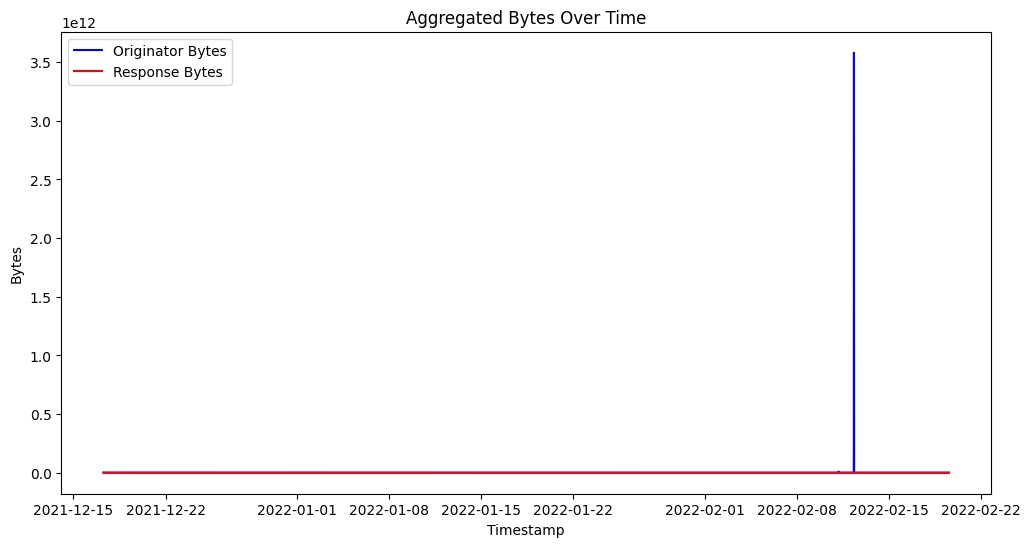

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

#Convert the Spark DataFrame to Pandas for visualization
df_pandas_sorted = df_agg_sorted.toPandas()

#Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_pandas_sorted['window_start'], df_pandas_sorted['sum_orig_bytes'], label = 'Originator Bytes', color = 'blue')
plt.plot(df_pandas_sorted['window_start'], df_pandas_sorted['sum_resp_bytes'], label = 'Response Bytes', color = 'red')

#Titles and Labels
plt.xlabel('Timestamp')
plt.ylabel('Bytes')
plt.title('Aggregated Bytes Over Time')
plt.legend()
plt.show()

Stationarity Test

In [15]:
#Check for Stationarity Using Augmented Dickey-Fuller (ADF) Test
#Consider p-value threshold of 0.05
from statsmodels.tsa.stattools import adfuller

#Perform ADF test on the 'sum_orig_bytes' time series
result = adfuller(df_pandas_sorted['sum_orig_bytes'].dropna())

#Extract and print test statistics
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values: ')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

#Interpret the result
if result[1] < 0.05:
    print("The time series is stationary (reject H0)")
else:
    print("The time series is non-stationary (fail to reject H0)")
          

ADF Statistic: -15.094171
p-value: 0.000000
Critical Values: 
	1%: -3.431
	5%: -2.862
	10%: -2.567
The time series is stationary (reject H0)


Plot of ACF and PACF from Stationary Series

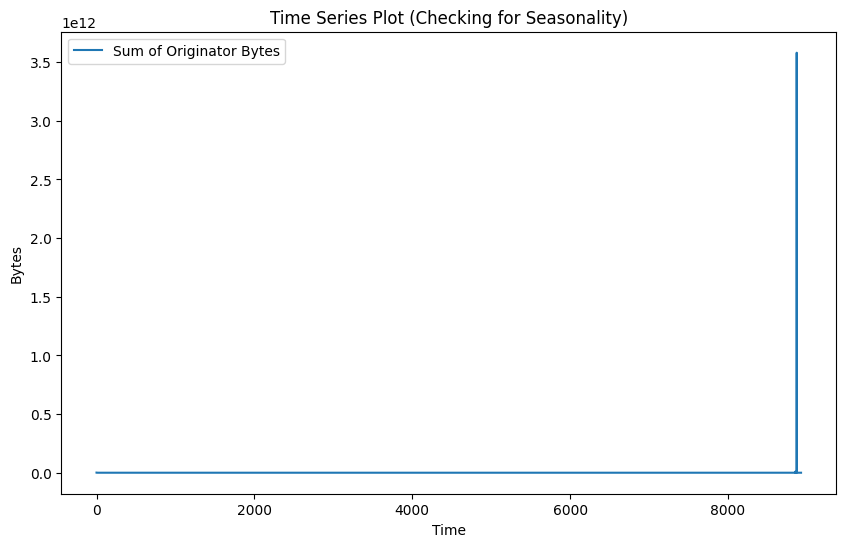

In [16]:
#Check for seasonality
import matplotlib.pyplot as plt

#Plot the original time series
plt.figure(figsize=(10,6))
plt.plot(df_pandas_sorted['sum_orig_bytes'], label='Sum of Originator Bytes')
plt.title('Time Series Plot (Checking for Seasonality)')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.show()

The time series does not show significant evidence of seasonality.


<Figure size 1000x600 with 0 Axes>

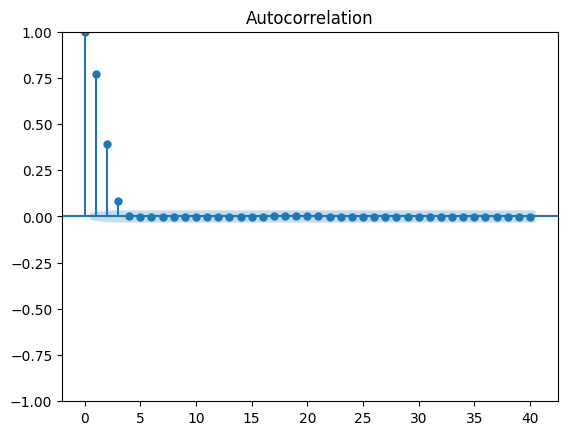

In [17]:
#Seasonality with ACF
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

#Calculate ACF Values
acf_values = acf(df_pandas_sorted['sum_orig_bytes'], nlags=50)

#Check for significant spikes at regular intervals
#Threshold for significance (Consider 1.96/sqrt(N), where N is the number of observations)
threshold = 1.96 / (len(df_pandas_sorted['sum_orig_bytes']) **0.5)

#Check for significant spikes at regular lags (e.g., lag 12, 24, 36 for monthly seasonality)
seasonal_lags = [12,24, 36] #Adjust based on the expected seasonality period
seasonal = False
for lag in seasonal_lags:
    if abs(acf_values[lag])>threshold:
        seasonal = True
        break

#Print a statement indicating if the series is seasonal or not
if seasonal:
    print("The time series shows evidence of seasonality.")
else:
    print("The time series does not show significant evidence of seasonality.")

#Plot the ACF for visual purposes
plt.figure(figsize=(10,6))
plot_acf(df_pandas_sorted['sum_orig_bytes'], lags=40)
plt.show()

Determine p and q values using auto_arima() instead of graphical interpretation#

In [18]:
#Install pmdarima if not already installed
#!pip install pmdarima

In [19]:
from pmdarima import auto_arima

#Running auto_arima on the entire DataFrame was too intensive, so use a testing set
#Define the portion of the DataFrame to use
df_sample = df_pandas_sorted.tail(1000) #Use the last 1000 rows

#Fit auto_arima to find optimal p,d,q values
auto_model = auto_arima(df_sample['sum_orig_bytes'],
                        start_p=0, max_p=10, #Range for p
                        start_q=0, max_q=10, #Range for q
                        d=0,                #Since the series is stationary, d=0
                        seasonal=False,     #Seasonality based on ACF test
                        #m=seasonal_period, #Seasonality manually set to False for testing
                        trace=True,         #Output the process
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

#Print the summary of the best model found
print(auto_model.summary())

#Get the best values of p,q, and d
p, d, q = auto_model.order
print(f"Best p: {p}, d: {d}, q: {q}")

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=54690.408, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=53784.335, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=53974.888, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=53482.934, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=53479.502, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=53407.625, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=53330.912, Time=0.21 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=53330.498, Time=0.07 sec
 ARIMA(7,0,0)(0,0,0)[0]             : AIC=53302.847, Time=0.09 sec
 ARIMA(8,0,0)(0,0,0)[0]             : AIC=53266.940, Time=0.17 sec
 ARIMA(9,0,0)(0,0,0)[0]             : AIC=53267.419, Time=0.12 sec
 ARIMA(8,0,1)(0,0,0)[0]             : AIC=53268.323, Time=0.40 sec
 ARIMA(7,0,1)(0,0,0)[0]             : AIC=53284.684, Time=0.38 sec
 ARIMA(9,0,1)(0,0,0)[0]             : AIC=53266.289, Time=0.66 sec
 ARIMA(10,0,1)(0,0,

Fit ARIMA Model

In [20]:
#SARIMAX is used if seasonal data may exist
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Define ARIMA model with selected p, d, q parameters
model = SARIMAX(df_pandas_sorted['sum_orig_bytes'], order=(15,0,15)) #d=0 because data is stationary #(p,d,q)

#Fit the model
model_fit = model.fit()

#Summary of the model
print(model_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54505D+01    |proj g|=  2.17670D-02

At iterate    5    f=  2.54432D+01    |proj g|=  3.95046D-02

At iterate   10    f=  2.54391D+01    |proj g|=  1.24341D-02

At iterate   15    f=  2.54386D+01    |proj g|=  9.86485D-03

At iterate   20    f=  2.54384D+01    |proj g|=  2.34785D-03

At iterate   25    f=  2.54384D+01    |proj g|=  7.92697D-04

At iterate   30    f=  2.54384D+01    |proj g|=  5.55961D-04

At iterate   35    f=  2.54384D+01    |proj g|=  7.59321D-04

At iterate   40    f=  2.54384D+01    |proj g|=  7.71583D-04

At iterate   45    f=  2.54384D+01    |proj g|=  1.44375D-03

At iterate   50    f=  2.54383D+01    |proj g|=  2.83312D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         sum_orig_bytes   No. Observations:                 8926
Model:             SARIMAX(15, 0, 15)   Log Likelihood             -227062.702
Date:                Sun, 10 Nov 2024   AIC                         454187.404
Time:                        14:41:59   BIC                         454407.403
Sample:                             0   HQIC                        454262.295
                               - 8926                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7079      1.583      1.079      0.281      -1.395       4.811
ar.L2         -0.6618      2.411     -0.275      0.784      -5.387       4.063
ar.L3         -1.4383      2.800     -0.514      0.6

Diagnostic Tests

    Ljung-Box p-value
10           0.989546
20           0.999614
30           0.999999
50           1.000000

Recommended lb_pvalue is > 0.05

Jarque-Bera Test:
JB Test Stat: 10516680522.55008, p-value: 0.0

Recommended p-value is > 0.05

Durbin-Watson Test:
Durbin-Watson Stat: 1.9960124427212362

Recommended stat close to 2.0 but not greater than 2.0

RMSE:
Root Mean Squared Error: 26975738114.4924


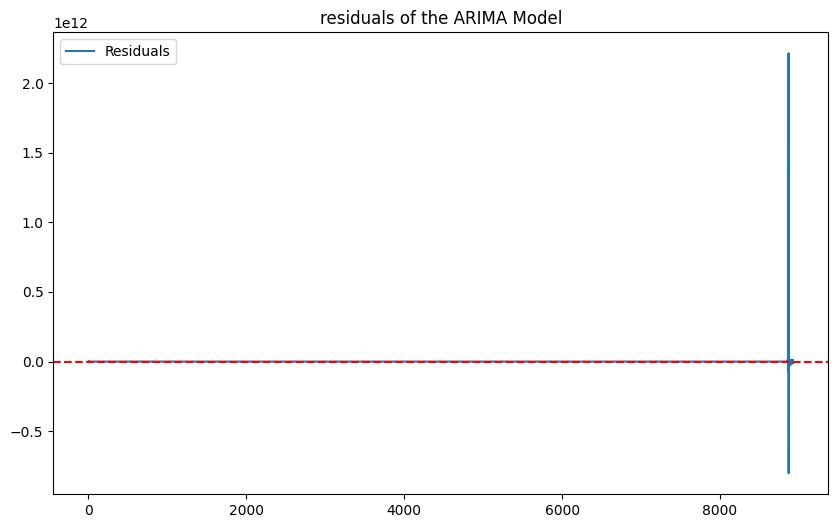

In [21]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
from statsmodels.stats.stattools import durbin_watson
import numpy as np

#Extract residuals
residuals = model_fit.resid

#Ljung-Box test for autocorrelation in residuals (Use multiple Lags)
lags = [10,20,30,50]
results = {}

#Perform Ljung-Box test across multiple lags
for lag in lags:
    lb_test = acorr_ljungbox(model_fit.resid, lags=[lag], return_df=True)
    results[lag] = lb_test['lb_pvalue'].values[0]

#Display the p-values for each Lag
print(pd.DataFrame.from_dict(results, orient='index',columns=['Ljung-Box p-value']))
print("\nRecommended lb_pvalue is > 0.05")

'''
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung-Box Test:")
print(ljung_box_test)
print("\nRecommended lb_pvalue is > 0.05")
'''

#Jarque-Bera test for normality of residuals
jb_test_stat, jb_p_value = jarque_bera(residuals)
print("\nJarque-Bera Test:")
print(f"JB Test Stat: {jb_test_stat}, p-value: {jb_p_value}")
print("\nRecommended p-value is > 0.05")

#Durbin-Watson test for autocorrelation in residuals
dw_stat = durbin_watson(residuals)
print("\nDurbin-Watson Test:")
print(f"Durbin-Watson Stat: {dw_stat}")
print("\nRecommended stat close to 2.0 but not greater than 2.0")

#Residual Standard Error (RMSE) test for relative performance
rmse = np.sqrt(np.mean(residuals**2))
print("\nRMSE:")
print(f"Root Mean Squared Error: {rmse}")

#Residual Plot (Optional for visual inspection)
plt.figure(figsize=(10,6))
plt.plot(residuals, label="Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("residuals of the ARIMA Model")
plt.legend()
plt.show()

In [22]:
#Apply log transformation to data and refit to ARIMA model to stabalize variance and make residuals closer to normality

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=54690.408, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=53784.335, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=53974.888, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=53482.934, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=53479.502, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=53407.625, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=53330.912, Time=0.16 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=53330.498, Time=0.13 sec
 ARIMA(7,0,0)(0,0,0)[0]             : AIC=53302.847, Time=0.12 sec
 ARIMA(8,0,0)(0,0,0)[0]             : AIC=53266.940, Time=0.25 sec
 ARIMA(9,0,0)(0,0,0)[0]             : AIC=53267.419, Time=0.14 sec
 ARIMA(8,0,1)(0,0,0)[0]             : AIC=53268.323, Time=0.37 sec
 ARIMA(7,0,1)(0,0,0)[0]             : AIC=53284.684, Time=0.36 sec
 ARIMA(9,0,1)(0,0,0)[0]             : AIC=53266.289, Time=0.59 sec
 ARIMA(10,0,1)(0,0,

 This problem is unconstrained.



At iterate    5    f=  8.71160D-01    |proj g|=  3.60472D-02

At iterate   10    f=  8.56948D-01    |proj g|=  4.84215D-02

At iterate   15    f=  8.53411D-01    |proj g|=  1.79804D-02

At iterate   20    f=  8.48866D-01    |proj g|=  4.08514D-02

At iterate   25    f=  8.45206D-01    |proj g|=  1.78757D-02

At iterate   30    f=  8.40089D-01    |proj g|=  5.04823D-02

At iterate   35    f=  8.35190D-01    |proj g|=  3.93293D-02

At iterate   40    f=  8.31055D-01    |proj g|=  2.45669D-02

At iterate   45    f=  8.28347D-01    |proj g|=  1.57017D-02


/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.27432D-01    |proj g|=  1.87888D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     58      1     0     0   1.879D-02   8.274D-01
  F =  0.82743187336148771     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                               SARIMAX Results                                
Dep. Variable:     log_sum_orig_bytes   No. Observations:                 8926
Model:             SARIMAX(15, 0, 15)   Log Likelihood               -7385.657
Date:                Sun, 10 Nov 2024   AIC                          14833.314
Time:                        14:42:35   BIC  

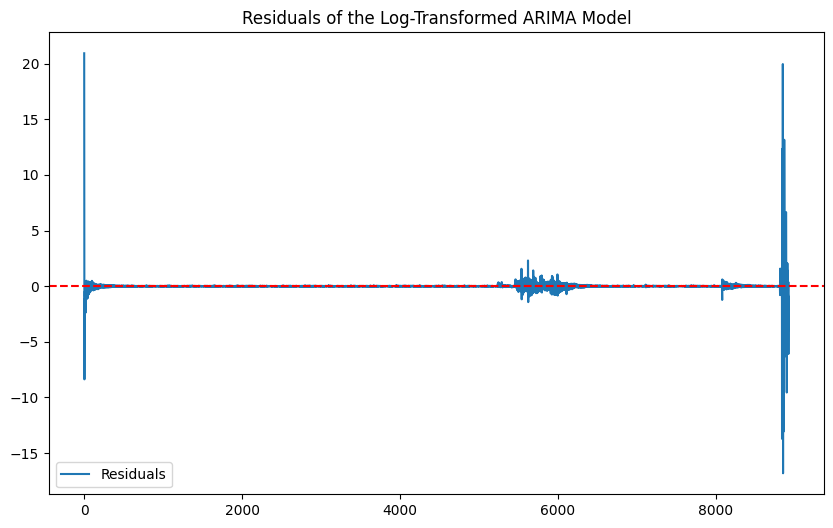

In [23]:
#Log-transform the data (ensure no zero values to avoid log(0) issues)
df_pandas_sorted['log_sum_orig_bytes'] = np.log1p(df_pandas_sorted['sum_orig_bytes'])  # log1p handles log(1 + x) to avoid log(0) issues

#Running auto_arima on the entire DataFrame was too intensive, so use a portion
#Define the portion of the DataFrame to use
df_sample = df_pandas_sorted.tail(1000) #Use the last 1000 rows

#Fit auto_arima to find optimal p,d,q values
auto_model = auto_arima(df_sample['sum_orig_bytes'],
                        start_p=0, max_p=50, #Range for p
                        start_q=0, max_q=10, #Range for q
                        d=0,                #Since the series is stationary, d=0
                        seasonal=False,     #Seasonality based on ACF test
                        #m=seasonal_period, #Seasonality manually set to False for testing
                        trace=True,         #Output the process
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

#Print the summary of the best model found
print(auto_model.summary())

#Get the best values of p,q, and d
p, d, q = auto_model.order
print(f"Best p: {p}, d: {d}, q: {q}")

#Fit ARIMA model on log-transformed data
model = SARIMAX(df_pandas_sorted['log_sum_orig_bytes'], order=(15, 0, 15))

#Fit the model
model_fit = model.fit()

#Summary of the model
print(model_fit.summary())

#Residual diagnostics
residuals = model_fit.resid

#Ljung-Box test for autocorrelation in residuals (Use multiple Lags)
lags = [10,20,30,50]
results = {}

#Perform Ljung-Box test across multiple lags
for lag in lags:
    lb_test = acorr_ljungbox(model_fit.resid, lags=[lag], return_df=True)
    results[lag] = lb_test['lb_pvalue'].values[0]

#Display the p-values for each Lag
print(pd.DataFrame.from_dict(results, orient='index',columns=['Ljung-Box p-value']))
print("\nRecommended lb_pvalue is > 0.05")

'''
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung-Box Test:")
print(ljung_box_test)
print("\nRecommended lb_pvalue is > 0.05")
'''

#Jarque-Bera test
jb_test_stat, jb_p_value = jarque_bera(residuals)
print("\nJarque-Bera Test:")
print(f"JB Test Stat: {jb_test_stat}, p-value: {jb_p_value}")

#Durbin-Watson test
dw_stat = durbin_watson(residuals)
print("\nDurbin-Watson Test:")
print(f"Durbin-Watson Stat: {dw_stat}")

# RMSE calculation
rmse = np.sqrt(np.mean(residuals**2))
print("\nRMSE:")
print(f"Root Mean Squared Error: {rmse}")

#Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals of the Log-Transformed ARIMA Model")
plt.legend()
plt.show()

Further Investigate Residuals

Outliers detected at the following indices:
0       20.930855
3       -8.374137
6       -3.038684
18      -2.376825
5622     2.307545
8840   -13.718561
8841    -4.582768
8842    -4.441595
8843    -6.413002
8844    12.343540
8846     2.726975
8847     3.390445
8848   -12.245154
8849    -3.215232
8850    19.960810
8853   -16.815511
8854     5.446085
8855    -3.428441
8856    -3.569185
8857   -13.095969
8860    -9.121041
8861    10.096223
8864    -3.919414
8866    -5.636053
8867    -5.650449
8868    13.157077
8869     9.126121
8870     3.234983
8871     5.124191
8875     1.864675
8879    -3.010474
8880    -6.303022
8881     5.767730
8884    -3.864477
8885     2.352140
8886    -2.159425
8887    -5.002953
8888    -4.303591
8889    -1.945711
8890    -3.057590
8891     6.655065
8894    -1.839008
8900    -9.557385
8902    -1.816665
8903    -2.540363
8904     2.053643
8906     2.069138
8910    -2.744529
8912    -2.045916
8915    -3.041669
8917    -2.433624
8918    -1.939232
8921    -6.094938
89

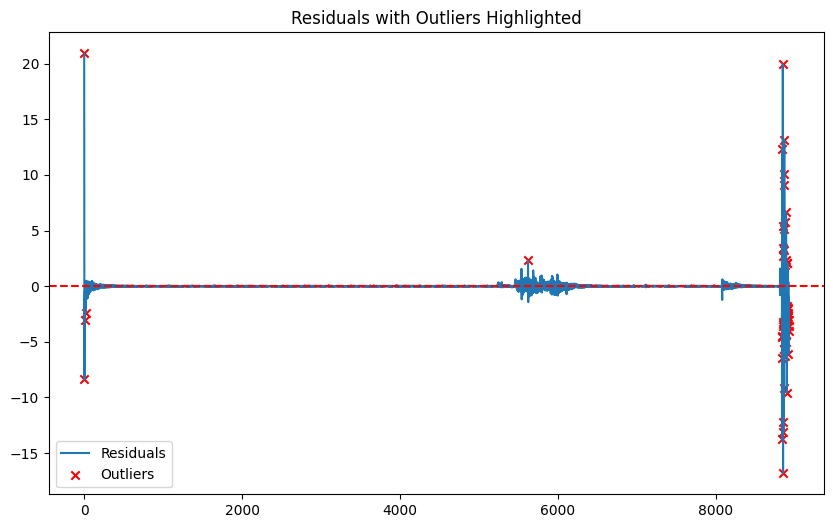

In [24]:
#Calculate the residuals from your fitted ARIMA model
residuals = model_fit.resid

#Calculate the mean and standard deviation of residuals
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)

#Set a threshold for outliers (e.g., 3 standard deviations)
outlier_threshold = 3 * residual_std

#Identify the outliers
outliers = residuals[(residuals > residual_mean + outlier_threshold) | (residuals < residual_mean - outlier_threshold)]

#Print the identified outliers
print("Outliers detected at the following indices:")
print(outliers)

#Plot the residuals with outliers highlighted
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals")
plt.scatter(outliers.index, outliers, color='red', label="Outliers", marker='x')
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals with Outliers Highlighted")
plt.legend()
plt.show()

Check for Structural Breaks

No structural break detected (p-value = 0.24202)


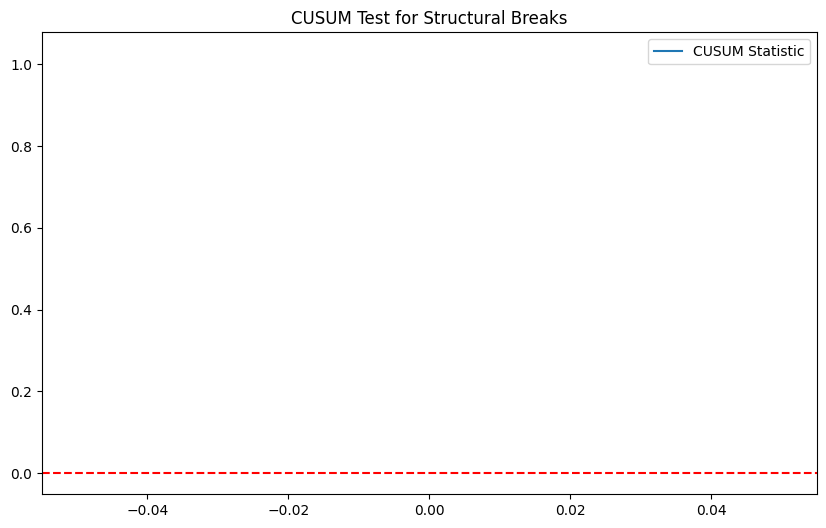

In [25]:
from statsmodels.stats.diagnostic import breaks_cusumolsresid

#Perform CUSUM test for structural breaks on residuals
cusum_test = breaks_cusumolsresid(model_fit.resid)

#Interpret the result
if cusum_test[1] < 0.05:
    print(f"Structural break detected (p-value = {cusum_test[1]:.5f})")
else:
    print(f"No structural break detected (p-value = {cusum_test[1]:.5f})")

#Plot the CUSUM statistic if you want a visual representation
plt.figure(figsize=(10, 6))
plt.plot(cusum_test[0], label="CUSUM Statistic")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("CUSUM Test for Structural Breaks")
plt.legend()
plt.show()

Compare Residuals to Network Logs

In [26]:
#Filter df_attacks for rows where label_tactic is not 'none'
df_attacks_filtered = df_attacks.filter(col("label_tactic")!='none')

#Convert df_attacks to a pandas DataFrame
df_attacks_pandas = df_attacks_filtered.toPandas()

#Create DatFrame of residuals with time stamps
residuals_df = pd.DataFrame({
    'window_start': df_pandas_sorted['window_start'],
    'residuals':residuals
})

#Merge residuals with df_attacks on timestamp
df_merged = residuals_df.merge(df_attacks, left_on='window_start', right_on='ts', how='inner')

#Filter for rows where 'Label_tactic' is not 'none' to see potential anomalies
df_anomalies = df_merged[df_merged['label_tactic'] != 'none']

#Display the DataFrame
df_anomalies.show(5, truncate=False)

#Plot residuals over time
plt.figure(figsize=(14,7))
plt.plot(residuals_df['window_start'],residuals_df['residuals'], label='Residuals', color='blue')

#Highlight anomalies by plotting points where 'label_tactic' is not 'none'
plt.scatter(df_anomalies['window_start'], df_anomalies['residuals'], color='red', marker='o', label='Anomalies')

#Add labels and legend
plt.xlabel('Timestamp')
plt.ylabel('Residuals')
plt.title('Residuals with Detected Anomalies')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

#Show the plot
plt.show()

ERROR:root:Exception while sending command.                                     
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


AssertionError: Undefined error message parameter for error class: CANNOT_PARSE_DATATYPE. Parameters: {'error': 'An error occurred while calling o156.schema'}

In [ ]:
forecast = model_fit.forecast(steps=10)
print(forecast)

#LATER PROCESSING: SPLIT INTO SEPERATE DATAFRAMES ALL DATA AND MALICIOUS DATA ONLY
#ALL DATA: COUNT 
#ALL DATA: BYTES
#MALICIOUS DATA: COUNT
#MALICIOUS DATA: BYTES

In [ ]:
Model Diagnostics

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
